<body>
    <font size="2">Florian Schnabel, 11807470, SS 2023</font><br />
</body>

# Exercise 2 - Conduction and Convection with RC-Networks

This script aims to calculate the temperatures of an arbitrary number of nodes in a steady state. The script takes heatflows as a result of conduction, convection, heatsources and boundary conditions into account {numref}`fig:RC-Networks`.

```{figure} ./Figures/RC-Networks.png
---
width: 350px
name: fig:RC-Networks
---
Conveductance network with three nodes {cite}`hagenthoft2001`
```

## Fundamentals

### Conservation

As this application aims to calculate a steady state, the formulation of conservation of energy inside nodes can be simplified as follows {cite}`hagenthoft2001`:

$$\sum\limits Q_i = \sum\limits_{j=1}^{j=n}K_{j,i} \cdot (T_j - T_i) + I_{0,i} = 0$$ (gl:heatbalance) 

or in matrix notation:

$$\sum\limits Q = K \cdot T + I_{0} = 0$$ (gl:heatbalance_matr) 

with:
* $K_{i,j}\ \dots$ Conductivity matrix
* $T_i\ \dots$ Temperature of the inspected node
* $T_j\ \dots$ Temperature of the connected nodes 
* $I_{0,i}\ \dots$ Heatflow from sources and boundaries

### Conductivity, Convection and Conveductance

To solve the heat balance equations for a three node system (connected to eachother), a conductancy matrix in the following form can be used:

$$ K = \left [ 
\begin{array}{ccccccc}
    -K_1 & K_{12} & K_{13} \\
    K_{21} & -K_2 & K_{23} \\
    K_{31}& K_{32} & -K_3\\
\end{array}
\right] $$ (gl:cond_matr) 

If only conductance is taken into account the conductivities in the diagonal result in the negative sum of the conductivities to all connected nodes and boundaries:

$$ K_1 = K_{0,1} + K_{12} + K_{13} $$ (gl:diagoconduct) 

Taking convection into account (often reffered to as conveductances {cite}`hagenthoft2001`) adds a dependency on direction to the conductances. Therefore $K_{ij} \neq K_{ji}$. For the three node system {eq}`gl:diagoconduct` remains true, but the now directional conveductances can be further split up:

$$ K_{12} =  K_{12}^* +  K_{12}^a \qquad \text{and} \qquad  K_{21} =  K_{12}^* +  K_{12}^a $$(gl:offdiagoconduct) 

with:
* $K_{i,j}\ \dots$ conveductance from $i$ to $j$
* $K_{i,j}^*\ \dots$ conductance between $i$ and $j$
* $K_{i,j}^a\ \dots$ convection interpreted as conduction as a result of airflow from $i$ to $j$

The heatflow as a result of convection can be descriped by the product of the energy carried by the air and the massflow of the air.

$$Q = E \cdot \dot{M}= c_a T \dot{M}  \qquad \text{and} \qquad  Q = KT$$(gl:energy1) 
$$\Longrightarrow K^a = c_a \cdot \dot{M}$$(gl:energy2) 

## Implementation

In [1]:
%reset

#Libraries
import numpy as np
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Class definition

In [2]:
class node:
    # n summarizes the number of all nodes
    n=0
    def __init__(self, number,location):
        self.number = number
        self.location = location
        node.n += 1

In [3]:
class convection:
    def __init__(self, fromNode, toNode, massflow):
        self.fromNode = fromNode
        self.toNode = toNode
        self.massflow = massflow

In [4]:
class conduction:
    def __init__(self, fromNode, toNode, conductance):
        self.fromNode = fromNode
        self.toNode = toNode
        self.K = conductance
        

In [5]:
class boundary:
    def __init__(self, toNode, temp, conductance):
        self.toNode = toNode
        self.temp = temp
        self.K = conductance

In [6]:
class heatSource:
    def __init__(self, toNode, power):
        self.toNode = toNode
        self.power = power

### Construction of the node, convection and conduction objects
Input Values according to the excersise description with the following units:
* [$T$]= $^\circ C$
* [$I$]= $W C$
* [$\overset{.}{M}$]= $kg s^{-1}$


In [7]:
nodes = []
nodes.append(node(1,[1,0]))
nodes.append(node(2,[0,0]))
nodes.append(node(3,[0,1]))

boundaries = []
boundaries.append(boundary(1,19,0.1))
boundaries.append(boundary(2,25,0.1))
boundaries.append(boundary(3,0,0.1))

convections = []
convections.append(convection(1,2,0.05))
convections.append(convection(3,2,0.05))
convections.append(convection(1,3,0))

conductions = []
conductions.append(conduction(1,2,0.1))
conductions.append(conduction(2,3,0.1))
conductions.append(conduction(1,3,0.1))

In [8]:
heatSources = []
heatSources.append(heatSource(1,10))
heatSources.append(heatSource(2,20))
heatSources.append(heatSource(3,10))

In [9]:
ca = 1000 #J/kgK

### Variant 1 - without convection

#### Construction of the $K$ matrix and the boundary vector $I_0$

In [10]:
# reference number of nodes to increase readability
n = nodes[0].n

# Initialising conductivity matrix K
K = np.zeros((n,n))

# Initialising boundary vector I0
I0 = np.zeros((n))

# iterater to keep track of cell numbers
for node in nodes:
    #initialize empty conductivity matrix for the current layer
    I0i=0
    Ki=0

    #Test for connected Boundaries, Sources and Nodes
    for boundary in boundaries:
        if boundary.toNode == node.number:
            Ki += boundary.K
            I0i += boundary.K*boundary.temp
        
    for heatSource in heatSources:
        if heatSource.toNode == node.number:
            I0i += heatSource.power
            
    for conduction in conductions:
        if conduction.toNode == node.number or conduction.fromNode == node.number:
            Ki += conduction.K
            
    for conduction in conductions:
        if conduction.toNode == node.number:
            K[node.number-1, conduction.fromNode-1]= conduction.K
            K[conduction.fromNode-1, node.number-1]= conduction.K
   
    #defining the diagonal axis
    K[node.number-1, node.number-1]= - Ki
    
    #defining the I0
    I0[node.number-1]= I0i

#### Calculating the temperature field

In [11]:
T=np.linalg.solve(K,-I0)

#### Plot the Results

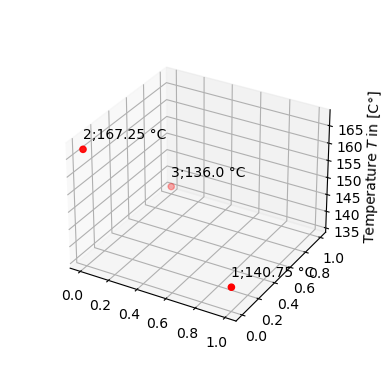

In [12]:
a= []
numbers=[]
i=0
for node in nodes:
    a.append(node.location + [T[i]])
    numbers.append(node.number)
    i+=1
    
a=np.array(a)
X, Y, Z = a[:,0], a[:,1], a[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, c='red')

for n, x, y, z,t in zip(numbers, X, Y, Z,T):
    label = "%d;"%(n)+ str(round(t,2)) + " °C"
    ax.text(x, y, z+ 0.1 * (np.max(Z)-np.min(Z)), label)
    
ax.set_zlabel("Temperature $T$ in [C°]")
ax.set_box_aspect(aspect=None, zoom=0.8)

### Variant 2 - with convection

#### Alteration of the $K$ matrix

In [13]:
for node in nodes:
    # Adding the heatflow induced by convection
    for convection in convections:
        if convection.fromNode == node.number:
            K[node.number-1 , node.number-1] += -convection.massflow * ca
            K[convection.toNode-1 , node.number-1] += convection.massflow * ca

#### Calculating the temperature field

In [14]:
T=np.linalg.solve(K,-I0)

#### Plot the Results

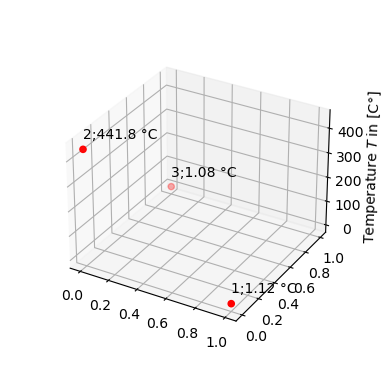

In [15]:
a= []
numbers=[]
i=0
for node in nodes:
    a.append(node.location + [T[i]])
    numbers.append(node.number)
    i+=1
    
a=np.array(a)
X, Y, Z = a[:,0], a[:,1], a[:,2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot_trisurf(X, Y, Z, color='white', edgecolors='grey', alpha=0.5)

ax.scatter(X, Y, Z, c='red')

for n, x, y, z,t in zip(numbers, X, Y, Z,T):
    label = "%d;"%(n)+ str(round(t,2)) + " °C"
    ax.text(x, y, z+ 0.1 * (np.max(Z)-np.min(Z)), label)
    
ax.set_zlabel("Temperature $T$ in [C°]")
ax.set_box_aspect(aspect=None, zoom=0.8)